In [1]:
import h5py  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

# Preprocessing

In [2]:
#If using GPU.
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
#read database.
f = h5py.File('GWdatabase.h5','r')   
f.keys()   

<KeysViewHDF5 ['reduced_data', 'waveforms', 'yeofrho']>

In [4]:
#create a list that contains all the failure cases.
fail_num = []
index = 0
for item in f['reduced_data']['tbounce(s)']:
    if(item == -1):
        fail_num.append(index)
    index += 1
fail_case = []
for index in fail_num:
    fail_case.append([f['reduced_data']['A(km)'][index],f['reduced_data']['omega_0(rad|s)'][index],f['reduced_data']['EOS'][index]])
fail_list= []
for item in fail_case:
    tmp = str(item[2]).split("b'")[1].split("'")[0]
    tmp = "A" + str(int(item[0])) + "w" + str(item[1]) + "0_" + tmp
    fail_list.append(tmp)    

# Choose which label we want to predict 

In [5]:
#get the label of w.
labels = []
index = 0
for item in f['waveforms']:
    if(item not in fail_list):
        labels.append(float(item.split('_')[0].split('w')[1]))
    index += 1

# Get data

In [6]:
#read image data.
from PIL import Image
import numpy as np
data = []
index = 0
for item in f['waveforms']:
    if(item not in fail_list):
        title = 'Final_tbounce/'+ str(index) + '.jpeg'
        image = Image.open(title).convert('L')
        data.append(np.array(image))
    index += 1

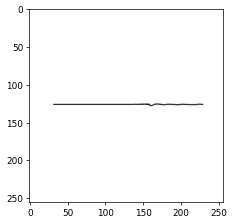

In [7]:
#check the data.
plt.figure(figsize=(4, 4), dpi=64)
plt.imshow(data[5], cmap='gray')

In [8]:
#transform the data type to numpy array
data = np.array(data)
X_train = data
y_train = labels

# Model

In [9]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
#from keras.utils import np_utilsy
from keras import backend as K
import os
import gc

In [10]:
X_train.shape

(1764, 256, 256)

In [11]:
#transfer the data shape for model training
X_train = X_train.reshape(X_train.shape[0], 256, 256, 1)

In [12]:
#using one hot to encode the label.
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(y_train)

def label_encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.to_categorical(enc)

def label_decode(le, one_hot_label):
    dec = np.argmax(one_hot_label, axis=1)
    return le.inverse_transform(dec)

y_train = label_encode(label_encoder, y_train)

In [13]:
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from keras.layers import Concatenate
from keras.models import Model

# Transfer Learning

In [14]:
model_encoder = Sequential()
model_encoder.add(Conv2D(64, (5, 5), input_shape=(256, 256, 1), padding="same", activation='relu'))
model_encoder.add(MaxPooling2D(pool_size=(2, 2)))
model_encoder.add(Conv2D(128, (5, 5), padding="same", activation='relu'))
model_encoder.add(MaxPooling2D(pool_size=(2, 2)))
model_encoder.add(Conv2D(256, (5, 5), padding="same", activation='relu'))
model_encoder.add(MaxPooling2D(pool_size=(2, 2)))
model_encoder.add(Conv2D(256, (3, 3), padding="same", activation='relu'))
model_encoder.add(MaxPooling2D(pool_size=(2, 2)))
model_encoder.add(Conv2D(256, (3, 3), padding="same", activation='relu'))
model_encoder.add(MaxPooling2D(pool_size=(2, 2)))
model_encoder.add(Dropout(0.5))
model_encoder.add(Flatten())
model_decoder = Sequential()
model_decoder.add(Dense(1024, activation='relu'))
model_decoder.add(Dense(512, activation='relu'))
model_decoder.add(Dense(128, activation='relu'))
model_decoder.add(Dense(32, activation='softmax'))

In [15]:
model_1 = Sequential()
model_1.add(model_encoder)
model_1.add(model_decoder)
optimizer = keras.optimizers.Adam(learning_rate=0.00001)
model_1.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [16]:
history = model_1.fit(x=X_train, y=y_train, epochs=40, batch_size=4)

Epoch 1/40
441/441 [==============================] - 17s 33ms/step - loss: 4.4818 - acc: 0.0443
Epoch 2/40
441/441 [==============================] - 15s 33ms/step - loss: 3.4164 - acc: 0.0375 0s - loss: 3.4172
Epoch 3/40
441/441 [==============================] - 15s 33ms/step - loss: 3.3478 - acc: 0.0585
Epoch 4/40
441/441 [==============================] - 15s 34ms/step - loss: 3.2226 - acc: 0.0900
Epoch 5/40
441/441 [==============================] - 15s 34ms/step - loss: 2.9095 - acc: 0.1412
Epoch 6/40
441/441 [==============================] - 15s 34ms/step - loss: 2.5819 - acc: 0.1561
Epoch 7/40
441/441 [==============================] - 15s 34ms/step - loss: 2.3369 - acc: 0.2247
Epoch 8/40
441/441 [==============================] - 15s 34ms/step - loss: 2.1911 - acc: 0.2380
Epoch 9/40
441/441 [==============================] - 15s 34ms/step - loss: 2.0552 - acc: 0.2639
Epoch 10/40
441/441 [==============================] - 15s 34ms/step - loss: 1.9221 - acc: 0.2915 0s - loss: 

In [ ]:
#if the GPU is out of memory while testing, we may need to save the trained model, restart, then load the model. 
model_encoder.save('TL_encoder_omega.h5')

In [25]:
model_encoder = keras.models.load_model('TL_encoder_omega.h5')

In [26]:
#TRANSFER LEARNING
a = []
f = h5py.File('20210705.h5','r')   
index = 0
for item in f:
    check = np.array(f[item])
    if(check.size > 0):
        if(float(item.split('w')[1]) < 6.1):
            if(item.split('w')[0] != 'A467'):
                a.append(index)
            index+=1

In [27]:
#TRANSFER LEARNING
from PIL import Image
import numpy as np
X_train = []
X_test = []
for i in range(60): 
    if(i in a):
        title = 'test_new/'+ str(i) + '.jpeg'
        image = Image.open(title).convert('L')
        X_train.append(np.array(image))
    else:
        title = 'test_new/'+ str(i) + '.jpeg'
        image = Image.open(title).convert('L')
        X_test.append(np.array(image))
y_train = []
y_test = []
f = h5py.File('20210705.h5','r')   
index = 0
for item in f:
    check = np.array(f[item])
    if(check.size > 0):
        if(float(item.split('w')[1]) < 6.1):
            if(index in a):
                y_train.append(float(item.split('w')[1]))
            else:
                y_test.append(float(item.split('w')[1]))
            index += 1
y_train = np.array(y_train)
y_test = np.array(y_test)
X_train = np.array(X_train)
X_test = np.array(X_test)

In [28]:
X_train = X_train.reshape(X_train.shape[0], 256, 256, 1)
X_test = X_test.reshape(X_test.shape[0], 256, 256, 1)

In [29]:
model_decoder2 = Sequential()
model_decoder2.add(Dense(1024, activation='relu'))
model_decoder2.add(Dense(512, activation='relu'))
model_decoder2.add(Dense(128, activation='relu'))
model_decoder2.add(Dense(1, activation='relu'))

In [30]:
model_encoder.trainable = True
model_2 = Sequential()
model_2.add(model_encoder)
model_2.add(model_decoder2)
optimizer = keras.optimizers.Adam(learning_rate=0.000003)
model_2.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

In [43]:
history = model_2.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=100, batch_size=4)

12/12 [==============================] - 0s 39ms/step - loss: 0.1720 - mae: 0.3238 - val_loss: 0.2231 - val_mae: 0.3682


In [44]:
answer_2 = model_2.predict(X_test)

# Train the model on Richar's data

In [45]:
f = h5py.File('GWdatabase.h5','r')  
#get the label of w.
labels = []
index = 0
for item in f['waveforms']:
    if(item not in fail_list):
        labels.append(float(item.split('_')[0].split('w')[1]))
    index += 1
#read image data.
from PIL import Image
import numpy as np
data = []
index = 0
for item in f['waveforms']:
    if(item not in fail_list):
        title = 'Final_tbounce/'+ str(index) + '.jpeg'
        image = Image.open(title).convert('L')
        data.append(np.array(image))
    index += 1

In [46]:
#transform the data type to numpy array
data = np.array(data)
X_train = data
y_train = labels
y_train = np.array(y_train)
#transfer the data shape for model training
X_train = X_train.reshape(X_train.shape[0], 256, 256, 1)

In [47]:
#our model
model = Sequential()
model.add(Conv2D(64, (5, 5), input_shape=(256, 256, 1), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (5, 5), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (5, 5), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='relu'))
optimizer = keras.optimizers.Adam(learning_rate=0.000003)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

In [75]:
history = model.fit(x=X_train, y=y_train, epochs=100, batch_size=16)

Epoch 1/100
111/111 [==============================] - 8s 54ms/step - loss: 34.0673 - mae: 4.6114
Epoch 2/100
111/111 [==============================] - 6s 55ms/step - loss: 20.9456 - mae: 3.6823
Epoch 3/100
111/111 [==============================] - 6s 55ms/step - loss: 18.4016 - mae: 3.4382
Epoch 4/100
111/111 [==============================] - 6s 55ms/step - loss: 14.9659 - mae: 3.1015
Epoch 5/100
111/111 [==============================] - 6s 55ms/step - loss: 13.1375 - mae: 2.9350
Epoch 6/100
111/111 [==============================] - 6s 55ms/step - loss: 11.9523 - mae: 2.7886
Epoch 7/100
111/111 [==============================] - 6s 55ms/step - loss: 10.1003 - mae: 2.5248
Epoch 8/100
111/111 [==============================] - 6s 55ms/step - loss: 7.1320 - mae: 2.0578
Epoch 9/100
111/111 [==============================] - 6s 55ms/step - loss: 5.4531 - mae: 1.7894
Epoch 10/100
111/111 [==============================] - 6s 55ms/step - loss: 4.3124 - mae: 1.5801
Epoch 11/100
111/111 [

In [ ]:
#if the GPU is out of memory while testing, we may need to save the trained model, restart, then load the model. 
model.save('Omega_Cont.h5')

In [48]:
model = keras.models.load_model('Omega_Cont.h5')

In [49]:
answer = model.predict(X_test)

In [50]:
true = []
for i in range(14):
    true.append(i*0.5)

In [51]:
index = 0
mae = 0
for item in answer_2:
    print(item,y_test[index])
    mae += abs(item[0]-y_test[index])
    index+=1
print("mae",mae/12)

[0.3576311] 0.5
[0.7322973] 1.0
[1.1034969] 1.5
[1.9853213] 2.0
[2.4198437] 2.5
[3.3171659] 3.0
[3.6547902] 3.5
[4.4458766] 4.0
[4.5992327] 4.5
[4.215664] 5.0
[4.6599793] 5.5
[5.1242785] 6.0
mae 0.368212769428889


In [52]:
index = 0
mae = 0
for item in answer:
    print(item,y_test[index])
    mae += abs(item[0]-y_test[index])
    index+=1
print("mae",mae/12)

[1.2646691] 0.5
[1.1255358] 1.0
[1.5898265] 1.5
[1.8182561] 2.0
[2.2171807] 2.5
[2.5154135] 3.0
[2.7071548] 3.5
[3.4759088] 4.0
[3.545564] 4.5
[3.197634] 5.0
[3.365396] 5.5
[5.245442] 6.0
mae 0.7410068015257517


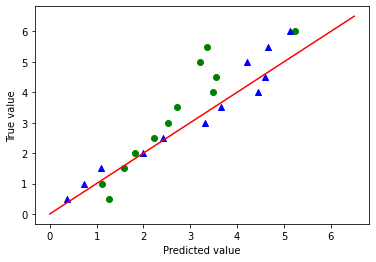

In [53]:
plt.plot(true,true,c='red')
plt.scatter(answer,y_test,c='green')
plt.scatter(answer_2,y_test,c='blue',marker="^")
plt.ylabel("True value") 
plt.xlabel('Predicted value') 
plt.savefig('TL.jpg')